## Importações

In [1]:
import os
import sox
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.optimize import minimize
import soundfile as sf
from scipy.signal import fftconvolve
from pydub import AudioSegment
from pydub.playback import play
import os
import logging
from scipy.spatial.distance import euclidean

## Exploração dos áudios e bibliotecas

In [2]:
AUDIOS_DIRECTORY = "/home/riosjoaop/Development/projects/ufba/lab3/audios"
OUTPUT_DIRECTORY = "output"

In [3]:
original, sr_original = librosa.load(f"{AUDIOS_DIRECTORY}/original.wav", sr=None)
revhall2, sr_revhall2 = librosa.load(f"{AUDIOS_DIRECTORY}/revhall2.wav", sr=None)

In [4]:
sr_original, sr_revhall2

(44100, 44100)

In [5]:
sf.write(f"{OUTPUT_DIRECTORY}/tests/audio_original.wav", original, sr_original)
sf.write(f"{OUTPUT_DIRECTORY}/tests/audio_revhall2.wav", revhall2, sr_revhall2)

In [6]:
S_original = librosa.amplitude_to_db(np.abs(librosa.stft(original)), ref=np.max)
S_revhall2 = librosa.amplitude_to_db(np.abs(librosa.stft(revhall2)), ref=np.max)

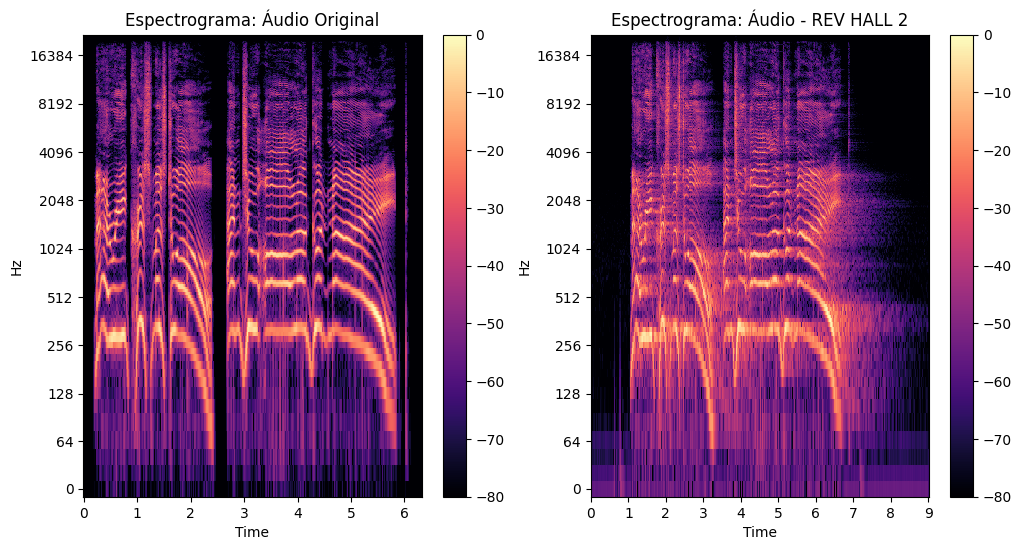

In [7]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
librosa.display.specshow(S_original, sr=sr_original, x_axis='time', y_axis='log', cmap='magma')
plt.title("Espectrograma: Áudio Original")
plt.colorbar()

plt.subplot(1, 2, 2)
librosa.display.specshow(S_revhall2, sr=sr_revhall2, x_axis='time', y_axis='log', cmap='magma')
plt.title("Espectrograma: Áudio - REV HALL 2")
plt.colorbar()

plt.show()

In [8]:
def apply_reverb(audio_path, output_path, attenuation_original=0.8, attenuation_echo=0.88, delay=60, decay=0.4):
    """
    Aplica reverb usando o ffmpeg diretamente.
    Args:
        audio_path (str): Caminho para o arquivo de áudio original.
        output_path (str): Caminho para salvar o áudio com reverb.
        attenuation_original (float): Intensidade do som original (0.0 a 1.0).
        attenuation_echo (float): Intensidade do eco (0.0 a 1.0).
        delay (int): Atraso do eco em milissegundos.
        decay (float): Dissipação do eco (0.0 a 1.0).
    """
    from ffmpeg import input, output, run
    
    reverb_filter = f"aecho={attenuation_original}:{attenuation_echo}:{delay}:{decay}"
    run(
        output(
            input(audio_path),
            output_path,
            **{"af": reverb_filter},
            format="wav"
        ),
        quiet=True
    )
    print(f"Áudio com reverb salvo em: {output_path}")

In [9]:
input_path = f"{AUDIOS_DIRECTORY}/original.wav"
output_path = f"{OUTPUT_DIRECTORY}/tests/reverb_pydub.wav"

apply_reverb(input_path, output_path)

audio_with_reverb = AudioSegment.from_file(output_path)
play(audio_with_reverb)

Áudio com reverb salvo em: output/tests/reverb_pydub.wav


Input #0, wav, from '/tmp/tmpodqemgt8.wav':   0KB sq=    0B f=0/0   
  Duration: 00:00:06.38, bitrate: 1411 kb/s
  Stream #0:0: Audio: pcm_s16le ([1][0][0][0] / 0x0001), 44100 Hz, 2 channels, s16, 1411 kb/s
   6.31 M-A: -0.000 fd=   0 aq=    0KB vq=    0KB sq=    0B f=0/0   

## Aplicação dos efeitos

In [10]:
def clean_temp_files(temp_dir):
    """Limpa os arquivos da pasta temporária."""
    if os.path.exists(temp_dir):
        # Remove todos os arquivos dentro da pasta temporária
        for file in os.listdir(temp_dir):
            file_path = os.path.join(temp_dir, file)
            if os.path.isfile(file_path):
                os.remove(file_path)
    else:
        print(f"A pasta temporária '{temp_dir}' não existe.")

In [11]:
import numpy as np
import librosa
import soundfile as sf
from ffmpeg import input, output, run

class AudioEffects:
    def __init__(self, sr):
        self.sr = sr

    def apply_reverb(self, audio, reverb_specs):
        """
        Aplica reverb ao áudio com parâmetros especificados.
        :param audio: Array NumPy do áudio.
        :param reverb_specs: Parâmetros do reverb [attenuation_original, attenuation_echo, delay, decay].
        :return: Áudio com reverb aplicado.
        """
        attenuation_original = reverb_specs[0]
        attenuation_echo = reverb_specs[1]
        delay = reverb_specs[2]
        decay = reverb_specs[3]

        af_filter = f"aecho={attenuation_original}:{attenuation_echo}:{delay}:{decay}"

        return self._process_audio_with_ffmpeg(audio, af_filter)

    def apply_pitch(self, audio, pitch):
        """
        Aplica alteração de pitch ao áudio.
        :param audio: Array NumPy do áudio.
        :param pitch: Alteração de pitch em semitons (positivo ou negativo).
        :return: Áudio com pitch alterado.
        """
        af_filter = f"asetrate={self.sr}*2^{pitch/12},aresample={self.sr}"

        return self._process_audio_with_ffmpeg(audio, af_filter)

    def normalize_audio(self, audio, target_peak=0.99):
        """
        Normaliza o áudio para atingir um pico desejado.
        :param audio: Array NumPy do áudio.
        :param target_peak: Valor de pico alvo (default: 0.99).
        :return: Áudio normalizado.
        """
        peak = np.max(np.abs(audio))
        if peak == 0:
            return audio
        return (audio / peak) * target_peak

    def _process_audio_with_ffmpeg(self, audio, af_filter):
        """
        Processa o áudio usando filtros do FFmpeg.
        :param audio: Array NumPy do áudio.
        :param af_filter: String com o filtro de áudio para aplicar (ex: "aecho", "asetrate").
        :return: Áudio processado.
        """

        clean_temp_files(f"{OUTPUT_DIRECTORY}/temp")
        
        temp_in = f"{OUTPUT_DIRECTORY}/temp/temp_input.wav"
        temp_out = f"{OUTPUT_DIRECTORY}/temp/temp_output.wav"

        # Salvar o áudio em um arquivo temporário
        sf.write(temp_in, audio, self.sr)

        # Aplicar o filtro do FFmpeg
        run(
            output(
                input(temp_in),
                temp_out,
                **{"af": af_filter},
                format="wav"
            ),
            quiet=True
        )

        # Carregar o áudio processado
        processed_audio, _ = librosa.load(temp_out, sr=self.sr)
        return processed_audio

### Funções auxiliares

In [12]:
def spectral_difference(audio1, audio2, sr):
    """
    Calcula a diferença espectral entre dois áudios.
    :param audio1: Áudio 1 (referência).
    :param audio2: Áudio 2 (processado).
    :param sr: Taxa de amostragem.
    :return: Diferença espectral entre os dois áudios.
    """
    # Ajustar o comprimento dos áudios (adicionar zeros ao menor)
    len1, len2 = len(audio1), len(audio2)
    if len1 < len2:
        audio1 = np.pad(audio1, (0, len2 - len1))
    elif len2 < len1:
        audio2 = np.pad(audio2, (0, len1 - len2))

    # Calcular os espectrogramas
    S1 = librosa.amplitude_to_db(np.abs(librosa.stft(audio1)), ref=np.max)
    S2 = librosa.amplitude_to_db(np.abs(librosa.stft(audio2)), ref=np.max)

    # Calcular o erro quadrático médio (MSE) entre os espectrogramas
    mse = np.mean((S1 - S2) ** 2)

    return mse

In [13]:
def objective(params, audio_target, audio_input, sr):
    """
    Função objetivo para otimizar parâmetros de reverb.
    :param params: Parâmetros otimizáveis (reverberance, damping, room_scale, stereo_depth).
    :param audio_target: Áudio de referência.
    :param audio_input: Áudio a ser processado.
    :param sr: Taxa de amostragem.
    :return: Diferença espectral entre o áudio processado e o de referência.
    """

    clean_temp_files("output/temp/")
    
    reverb_specs = params  # [reverberance, damping, room_scale, stereo_depth]
    
    effects = AudioEffects(sr)
    
    processed_audio = effects.apply_reverb(audio_input, reverb_specs)
    
    processed_audio = effects.normalize_audio(processed_audio)
    
    S1 = librosa.amplitude_to_db(np.abs(librosa.stft(audio_target)), ref=np.max)
    S2 = librosa.amplitude_to_db(np.abs(librosa.stft(processed_audio)), ref=np.max)
    mse = spectral_difference(audio_target, processed_audio, sr)

    clean_temp_files("output/temp/")
    
    return mse

### Carregando áudios - entrada e alvo

In [14]:
audio_input, sr_input = librosa.load(f"{AUDIOS_DIRECTORY}/original.wav", sr=None)
audio_target, sr_target = librosa.load(f"{AUDIOS_DIRECTORY}/revhall2.wav", sr=None)

In [15]:
sr_target, sr_input

(44100, 44100)

In [16]:
sr = sr_target

## Aplicando a otimização

In [17]:
initial_params = [1.0, 0.8, 100, 0.9]
bounds=[(0, 1), (0, 1), (0, 100), (0, 1)]

In [18]:
result = minimize(
    fun=objective,
    x0=initial_params,
    args=(audio_target, audio_input, sr),
    bounds=bounds,
    method='Nelder-Mead',
    options={
        'maxiter': 1000,
        'xatol': 1e-8,
        'fatol': 1e-8
    }
)

In [19]:
print(f"Parâmetros otimizados: {result.x}")
print(f"Valor da função objetivo: {result.fun}")

Parâmetros otimizados: [0.33407279 0.43938274 1.18981215 0.7130366 ]
Valor da função objetivo: 272.07501220703125


In [20]:
effects = AudioEffects(sr)

processed_audio = effects.apply_reverb(audio_input, result.x)
processed_audio = effects.normalize_audio(processed_audio)

In [21]:
sf.write("output/processed_audios/revhall2/audio_final_revhall2.wav", processed_audio, sr)

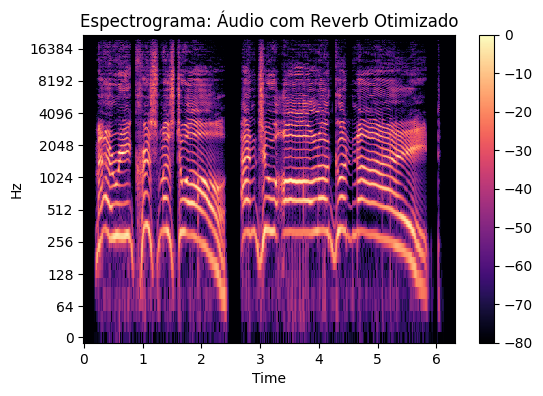

In [22]:
S_opt = librosa.amplitude_to_db(np.abs(librosa.stft(processed_audio)), ref=np.max)
plt.figure(figsize=(6, 4))
librosa.display.specshow(S_opt, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.title("Espectrograma: Áudio com Reverb Otimizado")
plt.colorbar()
plt.show()

## Avaliando o Resultado

In [23]:
def compare_waveforms(
    audio_name,
    audio_input,
    sr_input,
    audio_target,
    sr_target,
    audio_final,
    sr_final,
):

    time_target = np.linspace(0, len(audio_target) / sr_target, len(audio_target))
    time_input = np.linspace(0, len(audio_input) / sr_input, len(audio_input))
    time_final = np.linspace(0, len(audio_final) / sr_final, len(audio_final))
    
    plt.figure(figsize=(12, 8))

    plt.suptitle(f"Avaliação da Otimização - {audio_name}", fontsize=16, fontweight='bold')
    
    plt.subplot(3, 1, 1)
    plt.plot(time_input, audio_input, label="Áudio de Entrada - Original", color='orange')
    plt.title("Audio Input")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    
    plt.subplot(3, 1, 2)
    plt.plot(time_target, audio_target, label="Áudio Alvo - Rev Hall 2", color='blue')
    plt.title("Audio Target")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    
    plt.subplot(3, 1, 3)
    plt.plot(time_final, audio_final, label="Áudio Processado - ", color='green')
    plt.title("Áudio Final")
    plt.xlabel("Tempo (s)")
    plt.ylabel("Amplitude")
    plt.grid(True)
    
    plt.tight_layout()
    plt.savefig(f"{OUTPUT_DIRECTORY}/graphics/{audio_name}.png")
    plt.show()

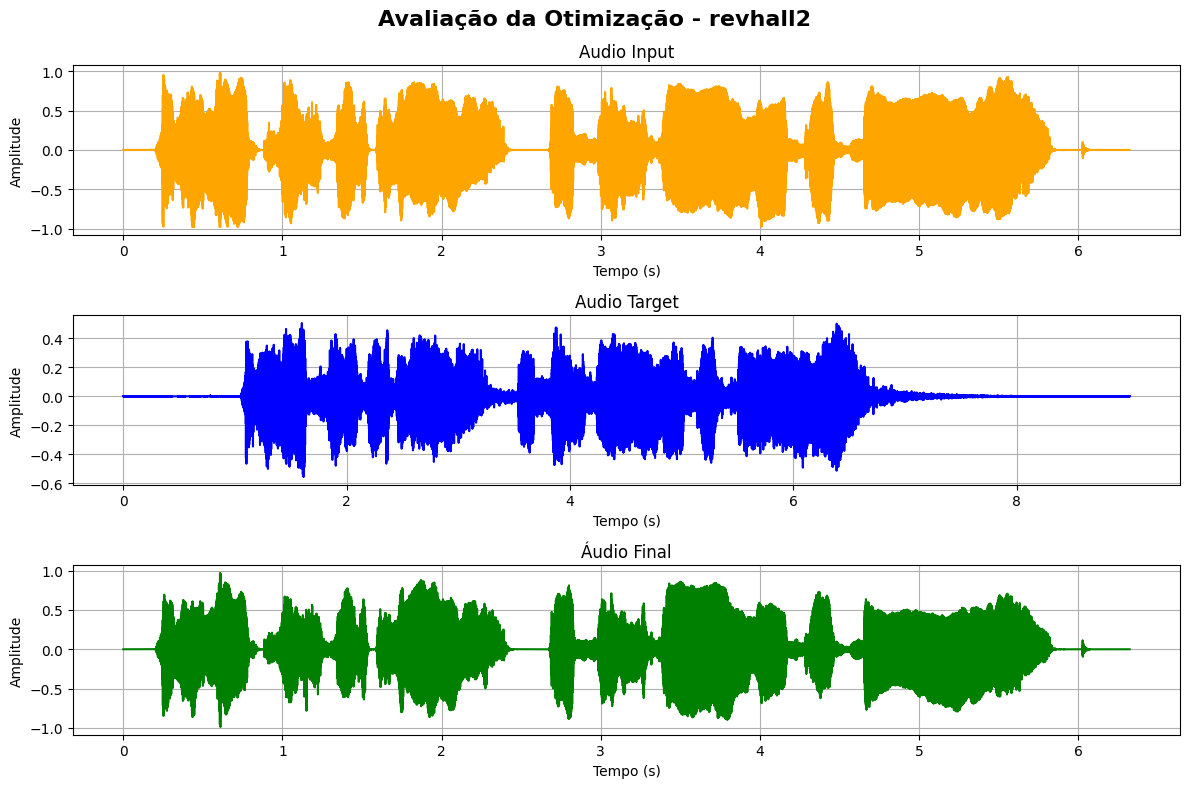

In [24]:
audio_input, sr_input = librosa.load(f"{AUDIOS_DIRECTORY}/original.wav", sr=None)
audio_target, sr_target = librosa.load(f"{AUDIOS_DIRECTORY}/revhall2.wav", sr=None)
audio_final, sr_final = librosa.load(f"{OUTPUT_DIRECTORY}/processed_audios/revhall2/audio_final_revhall2.wav", sr=None)

compare_waveforms("revhall2", audio_input, sr_input, audio_target, sr_target, audio_final, sr_final)

In [25]:
try:
    with open(f"{OUTPUT_DIRECTORY}/values/revhall2.txt", 'w', encoding='utf-8') as file:
        file.write(f"Params: {result.x}")
    print(f"Arquivo Rev Hall 2 criado com sucesso!")
except Exception as e:
    print(f"Ocorreu um erro ao criar o arquivo: {e}")

Arquivo Rev Hall 2 criado com sucesso!


## Outros Efeitos

In [26]:
bounds=[(0, 1), (0, 1), (0, 100), (0, 1)]

initial_params_dict = {
    "revstagea": [1.0, 0.6, 30, 0.4],  # Pequeno palco com reflexões rápidas
    "revstagebb": [1.0, 0.7, 40, 0.5],  # Palco médio com ecos moderados
    "revstagedb": [1.0, 0.8, 50, 0.6],  # Palco maior com decaimento mais longo
    "revstagefb": [1.0, 0.9, 60, 0.7],  # Palco grande com ecos bem perceptíveis
    "revstagegtht": [1.0, 1.0, 70, 0.8]  # Palco com eco denso e decaimento prolongado
}

def optimize_and_evaluate(input_file, target_file):
    audio_input, sr_input = librosa.load(f"{AUDIOS_DIRECTORY}/original.wav", sr=None)
    audio_target, sr_target = librosa.load(f"{AUDIOS_DIRECTORY}/revstagea.wav", sr=None)

    initial_params = initial_params_dict[target_file]
    
    result = minimize(
        fun=objective,
        x0=initial_params,
        args=(audio_target, audio_input, sr),
        bounds=bounds,
        method='Nelder-Mead',
        options={
            'maxiter': 1000,
            'xatol': 1e-8,
            'fatol': 1e-8
        }
    )

    print(f"Parâmetros otimizados - {target_file}: {result.x}")
    print(f"Valor da função objetivo - {target_file}: {result.fun}")

    effects = AudioEffects(sr)

    processed_audio = effects.apply_reverb(audio_input, result.x)
    processed_audio = effects.normalize_audio(processed_audio)

    sf.write(f"output/processed_audios/{target_file}/audio_final_{target_file}.wav", processed_audio, sr)

    audio_input, sr_input = librosa.load(f"{AUDIOS_DIRECTORY}/original.wav", sr=None)
    audio_target, sr_target = librosa.load(f"{AUDIOS_DIRECTORY}/revhall2.wav", sr=None)
    audio_final, sr_final = librosa.load(f"{OUTPUT_DIRECTORY}/processed_audios/revstagea/audio_final_revstagea.wav", sr=None)

    compare_waveforms(target_file, audio_input, sr_input, audio_target, sr_target, audio_final, sr_final)

    try:
        with open(f"{OUTPUT_DIRECTORY}/values/{target_file}.txt", 'w', encoding='utf-8') as file:
            file.write(f"Params: {result.x}")
        print(f"Arquivo {target_file} criado com sucesso!")
    except Exception as e:
        print(f"Ocorreu um erro ao criar o arquivo: {e}")

Parâmetros otimizados - revstagea: [3.81036504e-01 2.19154914e-03 2.96410369e+01 6.85953734e-01]
Valor da função objetivo - revstagea: 239.95730590820312


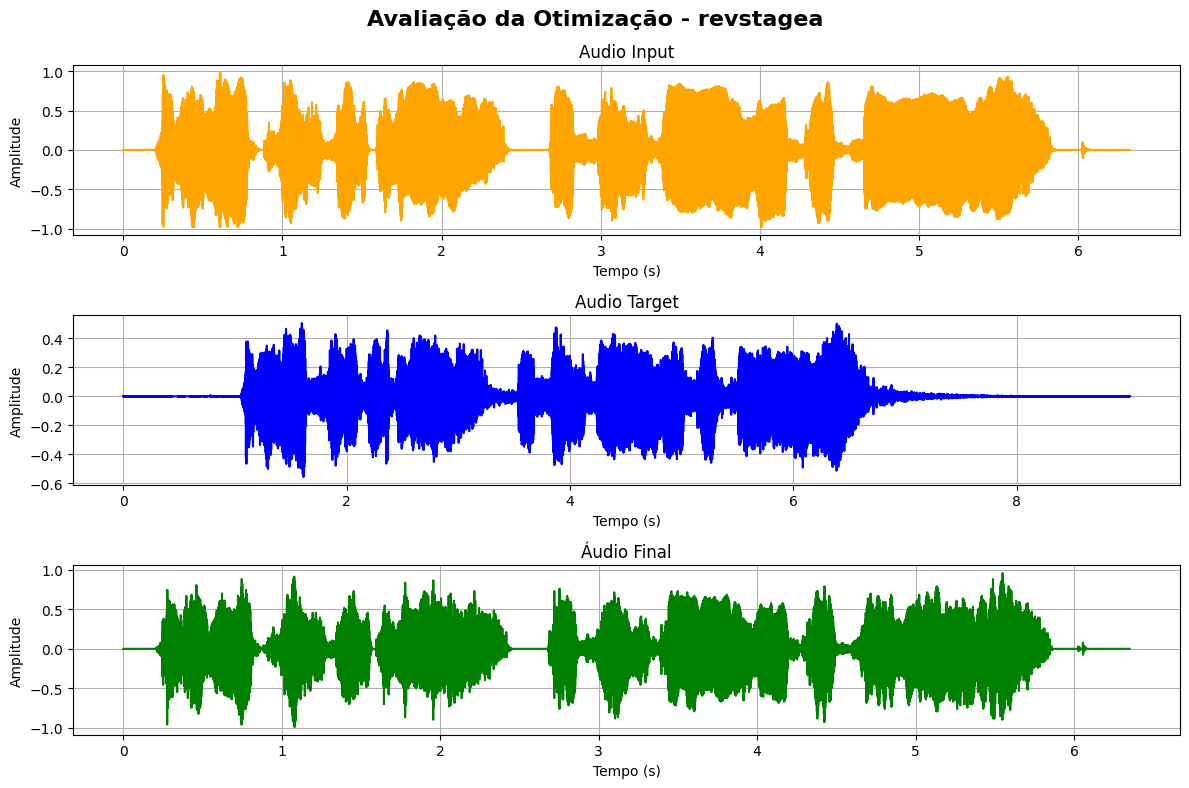

Arquivo revstagea criado com sucesso!
Parâmetros otimizados - revstagebb: [ 0.65440885  0.63892148 40.25671413  0.82292354]
Valor da função objetivo - revstagebb: 253.95497131347656


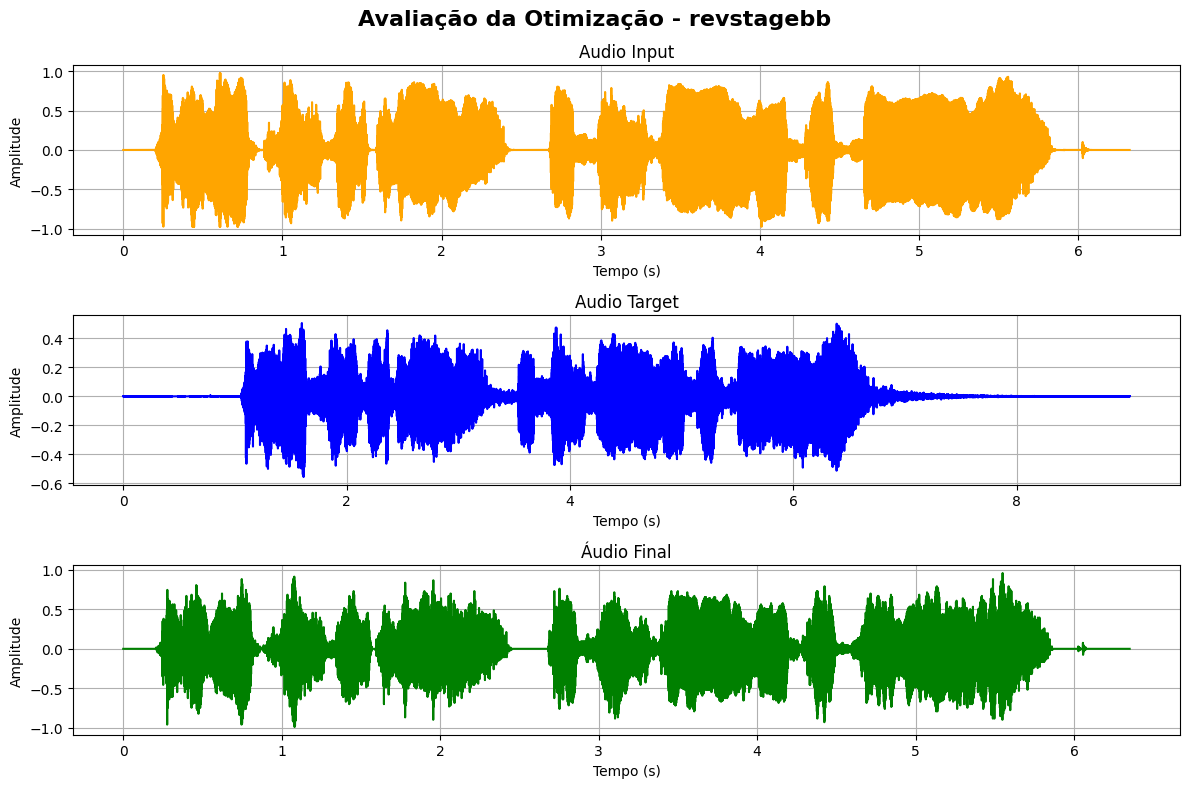

Arquivo revstagebb criado com sucesso!
Parâmetros otimizados - revstagedb: [ 0.7426167   0.52811185 47.98188613  0.71916999]
Valor da função objetivo - revstagedb: 253.96922302246094


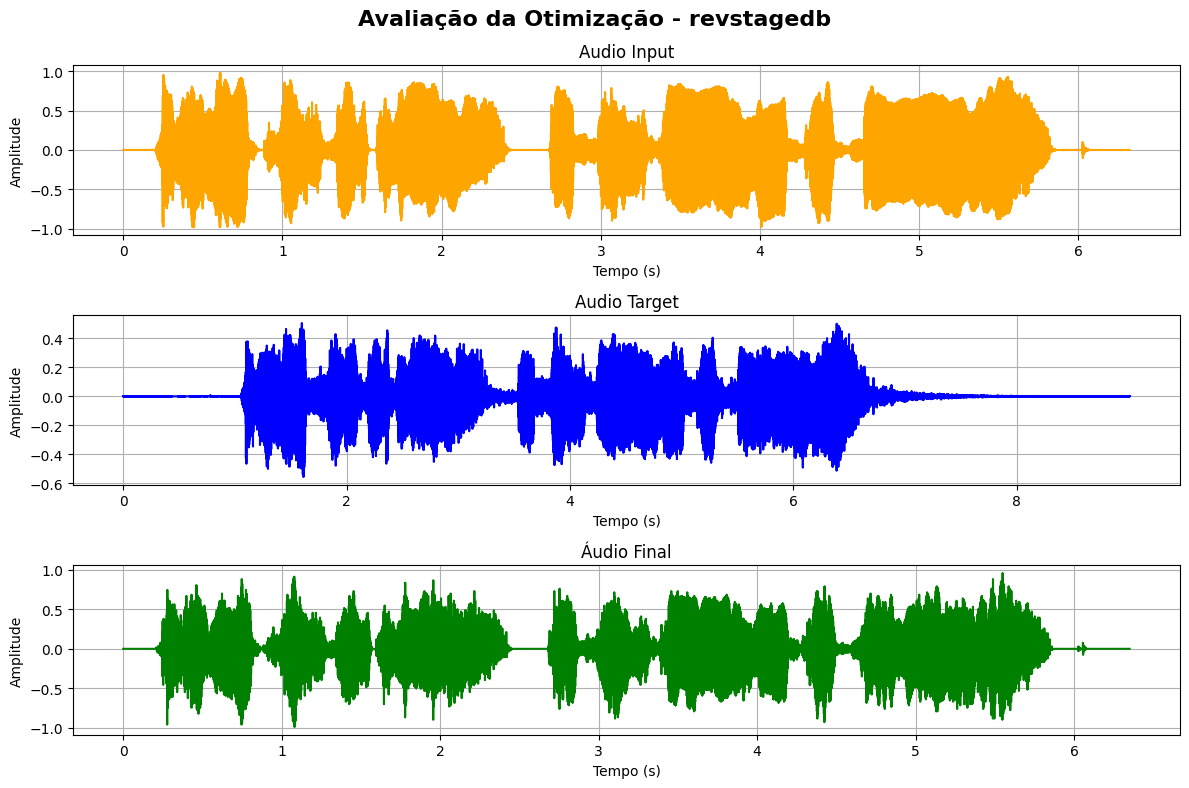

Arquivo revstagedb criado com sucesso!
Parâmetros otimizados - revstagefb: [ 0.98689798  0.90068122 60.98917545  0.6993919 ]
Valor da função objetivo - revstagefb: 254.13754272460938


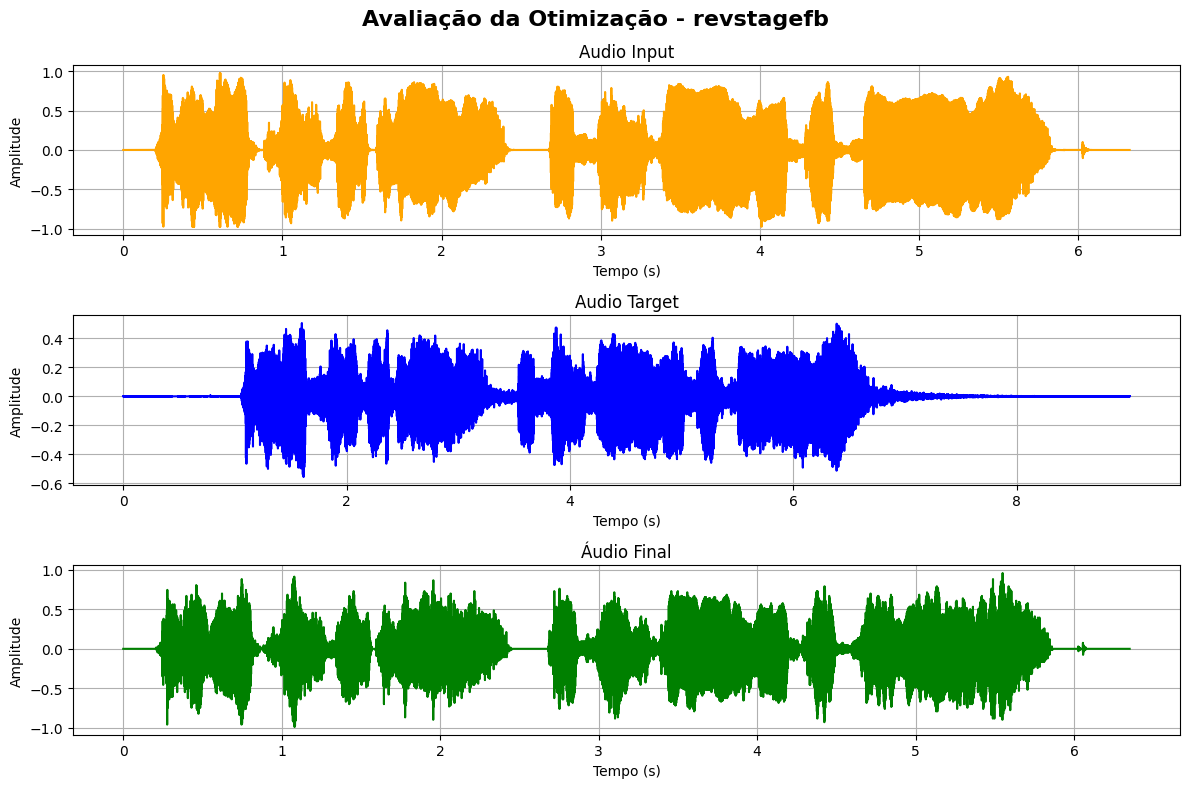

Arquivo revstagefb criado com sucesso!
Parâmetros otimizados - revstagegtht: [ 1.          1.         71.04484564  0.55740298]
Valor da função objetivo - revstagegtht: 253.490478515625


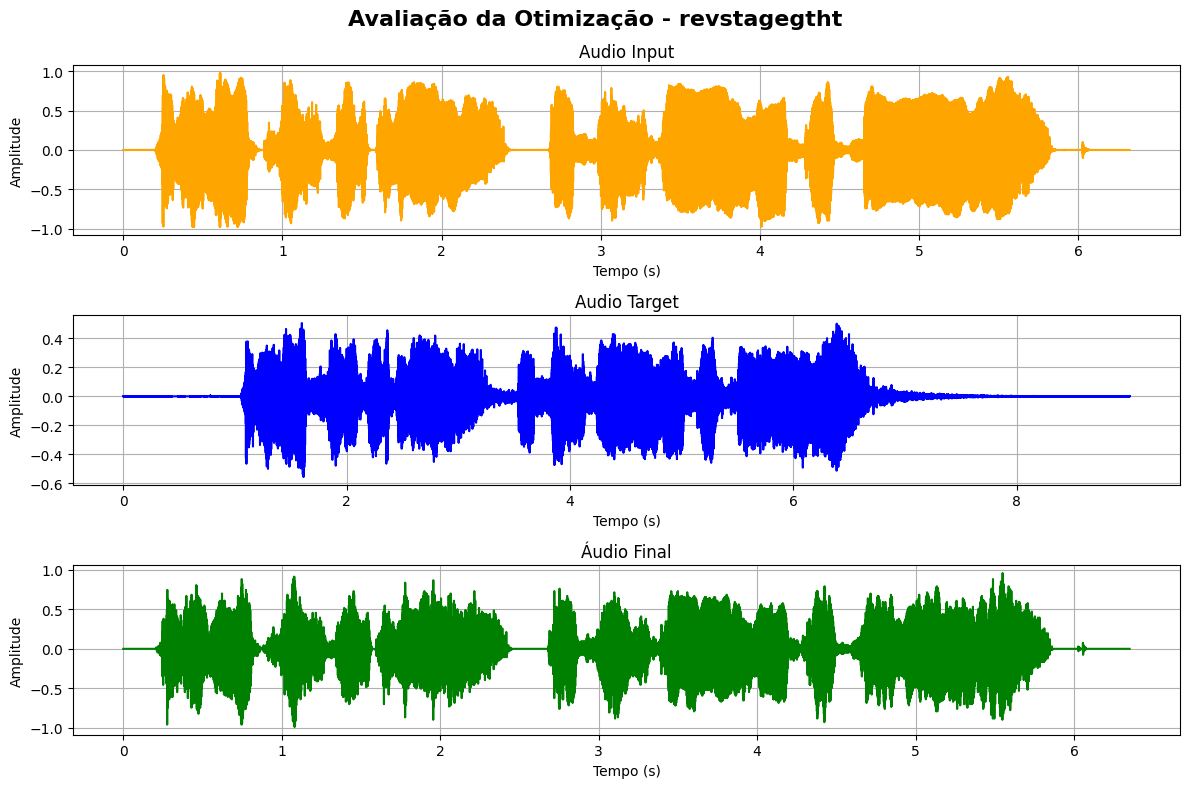

Arquivo revstagegtht criado com sucesso!


In [27]:
for file in ["revstagea", "revstagebb", "revstagedb", "revstagefb", "revstagegtht"]:
    optimize_and_evaluate("original", file)